In [101]:
import numpy as np
import random
from pymoo.core.problem import Problem
from pymoo.problems import get_problem
from pymoo.util.plotting import plot
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.visualization.scatter import Scatter

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize

from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

In [102]:
class TSPProblem(Problem):
    def __init__(self, n_cities, seed=50):
        # Define the number of variables (cities) and objectives (time and distance)
        super().__init__(n_var=n_cities, n_obj=2, n_constr=0, xl=0, xu=1)
        
        # Initialize the random seed for reproducibility
        if seed is not None:
            np.random.seed(seed)
        
        # Generate random distances and times between cities
        self.distances = np.random.uniform(0, 100, size=(n_cities, n_cities))
        self.distances = (self.distances + self.distances.T) / 2
        self.times = np.random.uniform(0, 300, size=(n_cities, n_cities))
        random.seed(None)
        
        # Ensure the diagonal is zero (distance/time from a city to itself is zero)
        np.fill_diagonal(self.distances, 0)
        np.fill_diagonal(self.times, 0)

    def _evaluate(self, x, out, *args, **kwargs):
        # Calculate the total distance and time for each solution in x
        distances = []
        times = []
        
        for route in x:
            perm = np.argsort(route)
            total_distance = 0
            total_time = 0
            
            for i in range(len(perm) - 1):
                total_distance += self.distances[perm[i], perm[i+1]]
                total_time += self.times[perm[i], perm[i+1]]
            
            # Add distance and time from last city back to the first city
            total_distance += self.distances[perm[-1], perm[0]]
            total_time += self.times[perm[-1], perm[0]]
            
            distances.append(total_distance)
            times.append(total_time)
        
        out["F"] = np.column_stack([distances, times])

In [103]:
problem = TSPProblem(100)
print(np.shape(problem.distances))
print(np.shape(problem.times))

(100, 100)
(100, 100)


In [104]:
def inicializar_poblacion(n_cities, n_individuals):
    """
    Inicializa la población con permutaciones de rutas.
    
    Parameters:
    - n_cities: Número de ciudades (tamaño del cromosoma).
    - n_individuals: Número de individuos en la población.
    
    Returns:
    - Una lista de individuos (rutas).
    """
    poblacion = []
    for _ in range(n_individuals):
        individuo = np.random.permutation(n_cities).tolist()
        poblacion.append(individuo)
    return poblacion

In [105]:
def evaluar_poblacion(problem, poblacion):
    """
    Evalúa una población en términos de los objetivos multiobjetivo definidos en TSPProblem.
    
    Parameters:
    - problem: Instancia del problema TSPProblem (definido con Pymoo).
    - poblacion: Lista de individuos (rutas) a evaluar.
    
    Returns:
    - valores_objetivo: Una lista de tuplas donde cada tupla representa (distancia, tiempo) para un individuo.
    """
    # Convertimos la población en un arreglo numpy para usarlo con Pymoo
    x = np.array(poblacion)

    # Diccionario para almacenar los resultados de evaluación
    resultados = {}
    problem._evaluate(x, resultados)

    # Extraemos los valores de los objetivos (distancia y tiempo)
    valores_objetivo = resultados["F"]

    return valores_objetivo

In [106]:
def calcular_crowding_distance(valores_objetivo):
    """
    Calcula la distancia de hacinamiento (crowding distance) para un conjunto de objetivos.
    
    Parameters:
    - valores_objetivo: Matriz de objetivos (N x M).
    
    Returns:
    - crowding: Array con la distancia de hacinamiento para cada solución.
    """
    n_ind, n_obj = valores_objetivo.shape
    crowding = np.zeros(n_ind)

    # Para cada objetivo, calcular la distancia crowding
    for m in range(n_obj):
        # Ordenar por el m-ésimo objetivo
        sorted_indices = np.argsort(valores_objetivo[:, m])
        sorted_obj = valores_objetivo[sorted_indices, m]

        # Asignar infinito a los extremos (frontera del rango)
        crowding[sorted_indices[0]] = np.inf
        crowding[sorted_indices[-1]] = np.inf

        # Calcular la distancia normalizada para los intermedios
        norm = sorted_obj[-1] - sorted_obj[0]
        if norm > 0:
            for i in range(1, n_ind - 1):
                crowding[sorted_indices[i]] += (
                    (sorted_obj[i + 1] - sorted_obj[i - 1]) / norm
                )

    return crowding

In [107]:
def seleccionar_poblacion(poblacion, valores_objetivo, n_individuals, T=2):
    """
    Realiza la selección por torneo para problemas multiobjetivo utilizando Pymoo.
    
    Parameters:
    - poblacion: Lista de individuos.
    - valores_objetivo: Matriz de valores objetivo (N x M).
    - n_individuals: Número de individuos a seleccionar.
    - T: Tamaño del torneo (default: 6).
    
    Returns:
    - padres: Lista de individuos seleccionados.
    """
    padres = []

    # Realizar torneo para seleccionar cada padre
    for _ in range(n_individuals):
        # Seleccionar T competidores al azar
        indices = np.random.choice(len(poblacion), size=T, replace=False)
        competidores = [poblacion[i] for i in indices]
        objetivos_competidores = valores_objetivo[indices]

        # Identificar los no dominados usando Pymoo
        nds = NonDominatedSorting()
        frentes = nds.do(objetivos_competidores, only_non_dominated_front=True)
        no_dominados = np.atleast_1d(frentes[0])  # Convertir siempre a array de al menos 1D

        if len(no_dominados) == 1:
            # Si hay un único no dominado, seleccionarlo
            ganador = competidores[no_dominados[0]]
        else:
            # Si hay empate, calcular distancia crowding
            crowding = calcular_crowding_distance(objetivos_competidores)
            idx_mejor = no_dominados[np.argmax(crowding[no_dominados])]
            ganador = competidores[idx_mejor]

        padres.append(ganador)

    return padres


In [108]:
def pmx_crossover(parent1, parent2, pcross):
    """
    Realiza un cruce PMX (Partially Mapped Crossover) entre dos padres con probabilidad de cruce.

    Parameters:
    - parent1: Individuo padre 1 (lista de ciudades).
    - parent2: Individuo padre 2 (lista de ciudades).
    - pcross: Probabilidad de cruce.

    Returns:
    - child1: Hijo 1 generado a partir de los padres.
    - child2: Hijo 2 generado a partir de los padres.
    """
    # Verificar si se realiza el cruce con la probabilidad dada
    if np.random.rand() >= pcross:
        # No realizar cruce, devolver copias de los padres
        return parent1[:], parent2[:]

    size = len(parent1)
    start, end = sorted(np.random.choice(range(size), 2, replace=False))  # Extremos de la máscara

    child1 = [-1] * size
    child2 = [-1] * size

    # Copiar segmento de parent1 a child1 y de parent2 a child2
    child1[start:end] = parent1[start:end]
    child2[start:end] = parent2[start:end]

    # Crear mapeos entre los segmentos
    mapping1 = {parent1[i]: parent2[i] for i in range(start, end)}
    mapping2 = {parent2[i]: parent1[i] for i in range(start, end)}

    def fill_child(child, parent, mapping):
        for i in range(size):
            if child[i] == -1:  # Si la posición está vacía
                gene = parent[i]
                while gene in mapping:
                    gene = mapping[gene]  # Resolver conflictos utilizando el mapeo
                child[i] = gene
        return child

    # Llenar los hijos utilizando los mapeos
    child1 = fill_child(child1, parent2, mapping1)
    child2 = fill_child(child2, parent1, mapping2)

    return child1, child2

In [109]:
def mutate_swap(ind, pmut):
    """
    Realiza una mutación por intercambio en un individuo.

    Parameters:
    - ind: Individuo a mutar (lista de ciudades).
    - pmut: Probabilidad de mutación.

    Returns:
    - ind: Individuo mutado.
    """
    for i in range(len(ind)):
        if np.random.rand() < pmut:
            j = np.random.randint(0, len(ind))
            ind[i], ind[j] = ind[j], ind[i]
    return ind


def mutate_insert(ind, pmut):
    """
    Realiza una mutación por inserción en un individuo.

    Parameters:
    - ind: Individuo a mutar (lista de ciudades).
    - pmut: Probabilidad de mutación.

    Returns:
    - ind: Individuo mutado.
    """
    for i in range(len(ind)):
        if np.random.rand() < pmut:
            gene = ind.pop(i)
            j = np.random.randint(0, len(ind))
            ind.insert(j, gene)
    return ind


def mutate_reverse(ind, pmut):
    """
    Realiza una mutación por inversión en un individuo.

    Parameters:
    - ind: Individuo a mutar (lista de ciudades).
    - pmut: Probabilidad de mutación.

    Returns:
    - ind: Individuo mutado.
    """
    if np.random.rand() < pmut:
        i, j = sorted(np.random.choice(range(len(ind)), 2, replace=False))
        ind[i:j] = reversed(ind[i:j])
    return ind


mutations = [mutate_swap, mutate_insert, mutate_reverse]

def mutate(ind, pmut):
    """
    Aplica un operador de mutación seleccionado aleatoriamente a un individuo.

    Parameters:
    - ind: Individuo a mutar.
    - pmut: Probabilidad de mutación.

    Returns:
    - Individuo mutado.
    """
    mutation_operator = np.random.choice(mutations)
    return mutation_operator(ind, pmut)

In [110]:
import random
import numpy as np

from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

def evolve(problem, n_generations, n_individuals, pcross, pmut, trace=10, T=2):
    """
    Evoluciona una población usando operadores genéticos para resolver un problema multiobjetivo TSP,
    e imprime la cantidad de soluciones no dominadas cada `trace` generaciones, incluyendo la final.
    """
    # Inicializar la población
    poblacion = inicializar_poblacion(problem.n_var, n_individuals)

    # Evaluar la población inicial
    valores_objetivo = evaluar_poblacion(problem, poblacion)

    # Preparar el NonDominatedSorting de pymoo
    nd_sort = NonDominatedSorting()

    # Recorremos de 1 a n_generations
    for gen in range(1, n_generations + 1):
        # Selección de padres usando torneo con tamaño T
        padres = seleccionar_poblacion(poblacion, valores_objetivo, n_individuals, T=T)

        # Crear una nueva población
        nueva_poblacion = []

        # Reproducción (cruce y mutación)
        while len(nueva_poblacion) < n_individuals:
            # Seleccionar dos padres al azar
            padre1, padre2 = random.sample(padres, 2)

            # Cruce PMX con probabilidad pcross
            hijo1, hijo2 = pmx_crossover(padre1, padre2, pcross)

            # Mutación de los hijos
            hijo1 = mutate(hijo1, pmut)
            hijo2 = mutate(hijo2, pmut)

            # Agregar hijos a la nueva población
            nueva_poblacion.append(hijo1)
            if len(nueva_poblacion) < n_individuals:
                nueva_poblacion.append(hijo2)

        # Actualizar la población
        poblacion = nueva_poblacion

        # Evaluar la nueva población
        valores_objetivo = evaluar_poblacion(problem, poblacion)

        # Cada `trace` generaciones y en la última, imprimimos la traza
        if (gen == 1) or (gen % trace == 0) or (gen == n_generations):
            nd_front = nd_sort.do(valores_objetivo, only_non_dominated_front=True)
            n_nd = len(nd_front)
            print(f"Generación {gen}: {n_nd} soluciones no dominadas.")

    nd_front = nd_sort.do(valores_objetivo, only_non_dominated_front=True)
    print(f"Final - {len(nd_front)} soluciones no dominadas")
    print("Final population size:", len(poblacion))
    print("Shape valores_objetivo:", valores_objetivo.shape)



    return poblacion, valores_objetivo

In [111]:
# Llamada a la función evolve
poblacion_final, valores_objetivo_final = evolve(
    problem=problem, 
    n_generations=1000, 
    n_individuals=100, 
    pcross=0.7, 
    pmut=1/100,  
    trace=100, 
    T=6
)


Generación 1: 5 soluciones no dominadas.
Generación 100: 17 soluciones no dominadas.
Generación 200: 54 soluciones no dominadas.
Generación 300: 6 soluciones no dominadas.
Generación 400: 59 soluciones no dominadas.
Generación 500: 55 soluciones no dominadas.
Generación 600: 59 soluciones no dominadas.
Generación 700: 60 soluciones no dominadas.
Generación 800: 21 soluciones no dominadas.
Generación 900: 50 soluciones no dominadas.
Generación 1000: 59 soluciones no dominadas.
Final - 59 soluciones no dominadas
Final population size: 100
Shape valores_objetivo: (100, 2)


In [112]:
nds_1 = NonDominatedSorting()
print("Fuera de evolve - Shape valores_objetivo_final:", valores_objetivo_final.shape)
nd_indices_test = nds_1.do(valores_objetivo_final, only_non_dominated_front=True)
print("Fuera de evolve - ND:", len(nd_indices_test))

Fuera de evolve - Shape valores_objetivo_final: (100, 2)
Fuera de evolve - ND: 59


Shape de valores_objetivo_nd: (59, 2)
Listado de puntos no dominados:
0: [3009.45986339 6128.07326343]
1: [3009.45986339 6128.07326343]
2: [3009.45986339 6128.07326343]
3: [3006.20891058 6629.1324833 ]
4: [3149.64753541 5777.04712706]
5: [3129.61091581 6071.8517379 ]
6: [3009.45986339 6128.07326343]
7: [3009.45986339 6128.07326343]
8: [3149.64753541 5777.04712706]
9: [3009.45986339 6128.07326343]
10: [3009.45986339 6128.07326343]
11: [3009.45986339 6128.07326343]
12: [3129.61091581 6071.8517379 ]
13: [3009.45986339 6128.07326343]
14: [3149.64753541 5777.04712706]
15: [3149.64753541 5777.04712706]
16: [3009.45986339 6128.07326343]
17: [3149.64753541 5777.04712706]
18: [3009.45986339 6128.07326343]
19: [3149.64753541 5777.04712706]
20: [3009.45986339 6128.07326343]
21: [3009.45986339 6128.07326343]
22: [3149.64753541 5777.04712706]
23: [3149.64753541 5777.04712706]
24: [3149.64753541 5777.04712706]
25: [3149.64753541 5777.04712706]
26: [3149.64753541 5777.04712706]
27: [3009.45986339 612

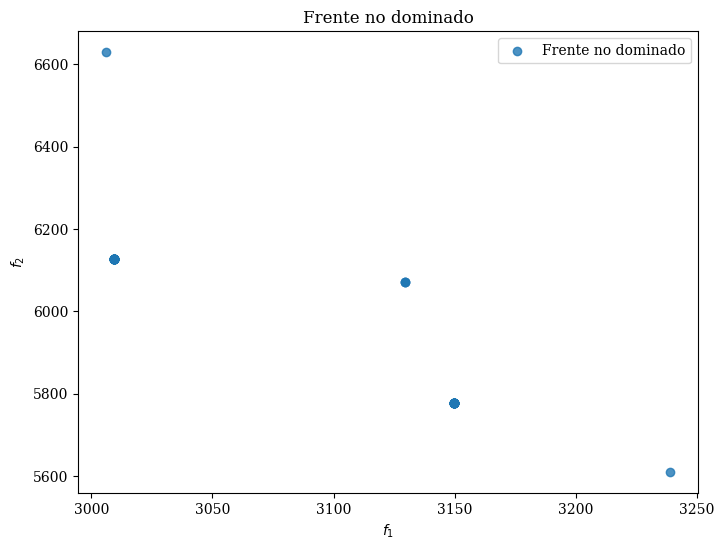

In [113]:
import numpy as np
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from pymoo.visualization.scatter import Scatter

# Supongamos que ya tienes 'valores_objetivo_final'
# y quieres obtener el frente no dominado:
nds = NonDominatedSorting()
nd_indices = nds.do(valores_objetivo_final, only_non_dominated_front=True)

valores_objetivo_nd = valores_objetivo_final[nd_indices]

# 1. Imprimir tamaño y contenido
print("Shape de valores_objetivo_nd:", valores_objetivo_nd.shape)
print("Listado de puntos no dominados:")
for i, val in enumerate(valores_objetivo_nd):
    print(f"{i}: {val}")

# 2. Revisar si hay duplicados exactos
# (np.unique con return_counts=True nos dice cuántas veces se repite cada fila)
unique_vals, counts = np.unique(valores_objetivo_nd, axis=0, return_counts=True)

print("\nChequeo de duplicados:")
for u, c in zip(unique_vals, counts):
    if c > 1:
        print(f"El vector {u} aparece {c} veces.")
    else:
        print(f"El vector {u} aparece 1 vez.")

# 3. Visualizar en scatter
plot = Scatter(title="Frente no dominado")
# Nota: puedes ajustar alpha para ver si se superponen puntos
plot.add(valores_objetivo_nd, label="Frente no dominado", alpha=0.8)
plot.legend = True
plot.show()


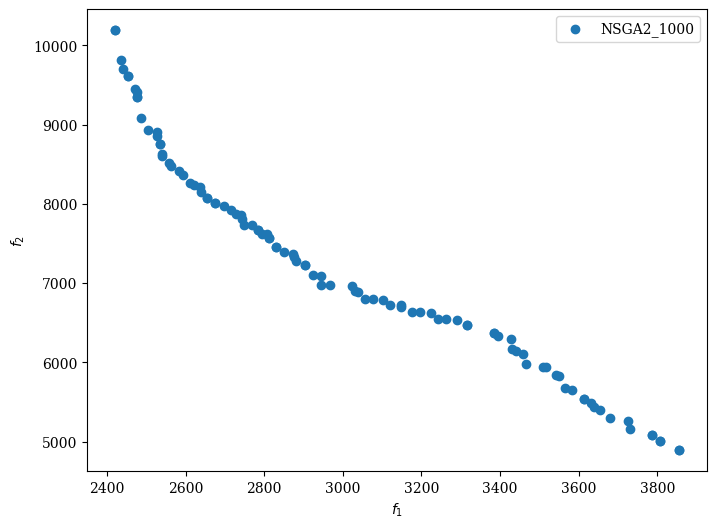

In [114]:
algorithm = NSGA2(pop_size=100)
res = minimize(problem,
               algorithm,
               ('n_gen', 1000),
               verbose=False)

scatter = Scatter()
scatter.add(res.F, label="NSGA2_1000")
scatter.legend=True
scatter.show()